Reference: [49] PyTorch [Tabular] —Multiclass Classification

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab 

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read Data
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/11_data_pre_processing_for_openpose/ekman/openpose_all_results_merged_without_NaN.csv")
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,731.249,198.399,0.850708,697.934,394.250,0.647540,547.098,388.432,0.472235,441.305,633.315,0.500294,319.825,715.615,0.220352,839.045,388.397,0.436088,905.637,629.376,0.322376,970.272,715.619,0.097874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006,output_video107.csv,anger,video01
1,1,2,729.332,204.230,0.843643,697.924,398.201,0.642926,552.978,388.398,0.473893,445.279,641.127,0.537712,360.990,715.630,0.142488,838.998,400.168,0.442338,905.639,647.009,0.445984,964.342,715.633,0.091682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570,output_video107.csv,anger,video01
2,2,3,729.285,206.162,0.852322,696.048,394.305,0.646629,549.073,390.386,0.453411,441.320,656.797,0.465288,0.000,0.000,0.000000,837.005,392.321,0.492424,897.794,637.200,0.353257,940.852,715.634,0.069541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,anger,video01
3,3,4,727.296,200.379,0.843100,695.904,388.418,0.641356,549.035,386.440,0.461498,447.248,652.873,0.382689,0.000,0.000,0.000000,835.056,388.400,0.498208,882.098,633.296,0.255498,913.474,715.622,0.120405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,anger,video01
4,4,5,723.424,196.431,0.855498,692.070,382.498,0.648065,545.154,384.500,0.494854,482.450,652.899,0.319641,0.000,0.000,0.000000,831.138,376.636,0.504424,858.628,582.348,0.347328,882.137,715.610,0.215963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,anger,video01


In [ ]:
df.tail()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
413274,464003,74,619.692,186.614,0.800948,580.400,337.440,0.362897,415.868,351.215,0.427184,351.182,543.170,0.093741,398.234,572.593,0.239182,742.995,321.807,0.195683,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219060,392.211,563.725,0.411907,404.101,560.753,0.368579,428.623,560.009,0.461416,446.457,560.753,0.531307,392.211,585.275,0.481759,410.045,584.531,0.438237,423.421,581.559,0.572969,440.512,580.073,0.732927,391.468,606.824,0.479390,413.761,614.998,0.593956,429.366,616.484,0.757715,446.457,614.998,0.820026,output_video75.csv,surprise,video14
413275,464004,75,635.238,192.472,0.811653,572.576,341.411,0.299112,417.793,353.100,0.402391,349.216,545.128,0.087107,0.000,0.000,0.000000,743.020,327.679,0.121451,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video75.csv,surprise,video14
413276,464005,76,648.952,190.533,0.649062,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video75.csv,surprise,video14
413277,464006,77,662.615,188.574,0.756530,558.850,339.433,0.130608,417.791,359.015,0.341286,351.175,560.803,0.128782,400.173,584.308,0.246592,695.989,333.548,0.074956,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.595007,414.004,563.221,0.493177,449.864,556.985,0.506456,465.455,556.985,0.419873,474.030,557.765,0.519911,419.461,587.388,0.502948,440.509,581.931,0.476449,457.659,578.813,0.494386,468.573,578.813,0.569922,426.477,612.333,0.576917,445.966,613.892,0.561140,457.659,613.892,0.667302,469.353,613.113,0.581568,output_video75.csv,surprise,video14
413278,464010,81,899.672,400.120,0.828228,956.535,431.453,0.300332,938.923,433.508,0.224136,0.000,0.000,0.000000,0.000,0.000,0.000000,966.382,421.703,0.425464,983.969,455.017,0.111255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video75.csv,surprise,video14


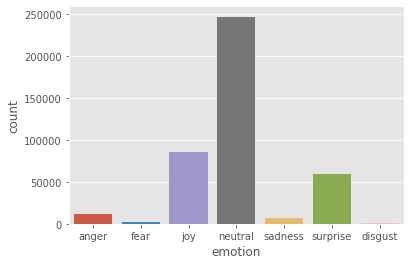

In [ ]:
# EDA and Preprocessing
# Class Distribution
sns.countplot(x = 'emotion', data=df)

In [ ]:
# Encode Output Class
class2idx = {
    'anger':0,
    'joy':1,
    'neutral':2,
    'surprise':3,
    'disgust':4,
    'sadness':5,
    'fear':6
}

idx2class = {v: k for k, v in class2idx.items()}

df['emotion'].replace(class2idx, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,731.249,198.399,0.850708,697.934,394.250,0.647540,547.098,388.432,0.472235,441.305,633.315,0.500294,319.825,715.615,0.220352,839.045,388.397,0.436088,905.637,629.376,0.322376,970.272,715.619,0.097874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006,output_video107.csv,0,video01
1,1,2,729.332,204.230,0.843643,697.924,398.201,0.642926,552.978,388.398,0.473893,445.279,641.127,0.537712,360.990,715.630,0.142488,838.998,400.168,0.442338,905.639,647.009,0.445984,964.342,715.633,0.091682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570,output_video107.csv,0,video01
2,2,3,729.285,206.162,0.852322,696.048,394.305,0.646629,549.073,390.386,0.453411,441.320,656.797,0.465288,0.000,0.000,0.000000,837.005,392.321,0.492424,897.794,637.200,0.353257,940.852,715.634,0.069541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,0,video01
3,3,4,727.296,200.379,0.843100,695.904,388.418,0.641356,549.035,386.440,0.461498,447.248,652.873,0.382689,0.000,0.000,0.000000,835.056,388.400,0.498208,882.098,633.296,0.255498,913.474,715.622,0.120405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,0,video01
4,4,5,723.424,196.431,0.855498,692.070,382.498,0.648065,545.154,384.500,0.494854,482.450,652.899,0.319641,0.000,0.000,0.000000,831.138,376.636,0.504424,858.628,582.348,0.347328,882.137,715.610,0.215963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,0,video01


In [ ]:
# Renaming a column
newcolumns = list(df.columns)
newcolumns[-1],newcolumns[-2]= newcolumns[-2],newcolumns[-1]
print (newcolumns)

['Unnamed: 0', 'frame', 'Nose_x', 'Nose_y', 'Nose_c', 'Neck_x', 'Neck_y', 'Neck_c', 'RShoulder_x', 'RShoulder_y', 'RShoulder_c', 'RElbow_x', 'RElbow_y', 'RElbow_c', 'RWrist_x', 'RWrist_y', 'RWrist_c', 'LShoulder_x', 'LShoulder_y', 'LShoulder_c', 'LElbow_x', 'LElbow_y', 'LElbow_c', 'LWrist_x', 'LWrist_y', 'LWrist_c', 'MidHip_x', 'MidHip_y', 'MidHip_c', 'RHip_x', 'RHip_y', 'RHip_c', 'RKnee_x', 'RKnee_y', 'RKnee_c', 'RAnkle_x', 'RAnkle_y', 'RAnkle_c', 'LHip_x', 'LHip_y', 'LHip_c', 'LKnee_x', 'LKnee_y', 'LKnee_c', 'LAnkle_x', 'LAnkle_y', 'LAnkle_c', 'REye_x', 'REye_y', 'REye_c', 'LEye_x', 'LEye_y', 'LEye_c', 'REar_x', 'REar_y', 'REar_c', 'LEar_x', 'LEar_y', 'LEar_c', 'LBigToe_x', 'LBigToe_y', 'LBigToe_c', 'LSmallToe_x', 'LSmallToe_y', 'LSmallToe_c', 'LHeel_x', 'LHeel_y', 'LHeel_c', 'RBigToe_x', 'RBigToe_y', 'RBigToe_c', 'RSmallToe_x', 'RSmallToe_y', 'RSmallToe_c', 'RHeel_x', 'RHeel_y', 'RHeel_c', 'face_point0_x', 'face_point0_y', 'face_point0_c', 'face_point1_x', 'face_point1_y', 'face_poi

In [ ]:
df = df.reindex(columns=newcolumns)
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
0,0,1,731.249,198.399,0.850708,697.934,394.250,0.647540,547.098,388.432,0.472235,441.305,633.315,0.500294,319.825,715.615,0.220352,839.045,388.397,0.436088,905.637,629.376,0.322376,970.272,715.619,0.097874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006,output_video107.csv,video01,0
1,1,2,729.332,204.230,0.843643,697.924,398.201,0.642926,552.978,388.398,0.473893,445.279,641.127,0.537712,360.990,715.630,0.142488,838.998,400.168,0.442338,905.639,647.009,0.445984,964.342,715.633,0.091682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570,output_video107.csv,video01,0
2,2,3,729.285,206.162,0.852322,696.048,394.305,0.646629,549.073,390.386,0.453411,441.320,656.797,0.465288,0.000,0.000,0.000000,837.005,392.321,0.492424,897.794,637.200,0.353257,940.852,715.634,0.069541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0
3,3,4,727.296,200.379,0.843100,695.904,388.418,0.641356,549.035,386.440,0.461498,447.248,652.873,0.382689,0.000,0.000,0.000000,835.056,388.400,0.498208,882.098,633.296,0.255498,913.474,715.622,0.120405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0
4,4,5,723.424,196.431,0.855498,692.070,382.498,0.648065,545.154,384.500,0.494854,482.450,652.899,0.319641,0.000,0.000,0.000000,831.138,376.636,0.504424,858.628,582.348,0.347328,882.137,715.610,0.215963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0


In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
0,1,731.249,198.399,0.850708,697.934,394.250,0.647540,547.098,388.432,0.472235,441.305,633.315,0.500294,319.825,715.615,0.220352,839.045,388.397,0.436088,905.637,629.376,0.322376,970.272,715.619,0.097874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006,output_video107.csv,video01,0
1,2,729.332,204.230,0.843643,697.924,398.201,0.642926,552.978,388.398,0.473893,445.279,641.127,0.537712,360.990,715.630,0.142488,838.998,400.168,0.442338,905.639,647.009,0.445984,964.342,715.633,0.091682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570,output_video107.csv,video01,0
2,3,729.285,206.162,0.852322,696.048,394.305,0.646629,549.073,390.386,0.453411,441.320,656.797,0.465288,0.000,0.000,0.000000,837.005,392.321,0.492424,897.794,637.200,0.353257,940.852,715.634,0.069541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0
3,4,727.296,200.379,0.843100,695.904,388.418,0.641356,549.035,386.440,0.461498,447.248,652.873,0.382689,0.000,0.000,0.000000,835.056,388.400,0.498208,882.098,633.296,0.255498,913.474,715.622,0.120405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0
4,5,723.424,196.431,0.855498,692.070,382.498,0.648065,545.154,384.500,0.494854,482.450,652.899,0.319641,0.000,0.000,0.000000,831.138,376.636,0.504424,858.628,582.348,0.347328,882.137,715.610,0.215963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0


In [ ]:
# Rewrite Unnamed: 0 to frame to start frame at 0
df["frame"]=df["frame"]-1
df.head()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
0,0,731.249,198.399,0.850708,697.934,394.250,0.647540,547.098,388.432,0.472235,441.305,633.315,0.500294,319.825,715.615,0.220352,839.045,388.397,0.436088,905.637,629.376,0.322376,970.272,715.619,0.097874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006,output_video107.csv,video01,0
1,1,729.332,204.230,0.843643,697.924,398.201,0.642926,552.978,388.398,0.473893,445.279,641.127,0.537712,360.990,715.630,0.142488,838.998,400.168,0.442338,905.639,647.009,0.445984,964.342,715.633,0.091682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570,output_video107.csv,video01,0
2,2,729.285,206.162,0.852322,696.048,394.305,0.646629,549.073,390.386,0.453411,441.320,656.797,0.465288,0.000,0.000,0.000000,837.005,392.321,0.492424,897.794,637.200,0.353257,940.852,715.634,0.069541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0
3,3,727.296,200.379,0.843100,695.904,388.418,0.641356,549.035,386.440,0.461498,447.248,652.873,0.382689,0.000,0.000,0.000000,835.056,388.400,0.498208,882.098,633.296,0.255498,913.474,715.622,0.120405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0
4,4,723.424,196.431,0.855498,692.070,382.498,0.648065,545.154,384.500,0.494854,482.450,652.899,0.319641,0.000,0.000,0.000000,831.138,376.636,0.504424,858.628,582.348,0.347328,882.137,715.610,0.215963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,video01,0


In [ ]:
df.tail()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
413274,73,619.692,186.614,0.800948,580.400,337.440,0.362897,415.868,351.215,0.427184,351.182,543.170,0.093741,398.234,572.593,0.239182,742.995,321.807,0.195683,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219060,392.211,563.725,0.411907,404.101,560.753,0.368579,428.623,560.009,0.461416,446.457,560.753,0.531307,392.211,585.275,0.481759,410.045,584.531,0.438237,423.421,581.559,0.572969,440.512,580.073,0.732927,391.468,606.824,0.479390,413.761,614.998,0.593956,429.366,616.484,0.757715,446.457,614.998,0.820026,output_video75.csv,video14,3
413275,74,635.238,192.472,0.811653,572.576,341.411,0.299112,417.793,353.100,0.402391,349.216,545.128,0.087107,0.000,0.000,0.000000,743.020,327.679,0.121451,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video75.csv,video14,3
413276,75,648.952,190.533,0.649062,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video75.csv,video14,3
413277,76,662.615,188.574,0.756530,558.850,339.433,0.130608,417.791,359.015,0.341286,351.175,560.803,0.128782,400.173,584.308,0.246592,695.989,333.548,0.074956,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.595007,414.004,563.221,0.493177,449.864,556.985,0.506456,465.455,556.985,0.419873,474.030,557.765,0.519911,419.461,587.388,0.502948,440.509,581.931,0.476449,457.659,578.813,0.494386,468.573,578.813,0.569922,426.477,612.333,0.576917,445.966,613.892,0.561140,457.659,613.892,0.667302,469.353,613.113,0.581568,output_video75.csv,video14,3
413278,80,899.672,400.120,0.828228,956.535,431.453,0.300332,938.923,433.508,0.224136,0.000,0.000,0.000000,0.000,0.000,0.000000,966.382,421.703,0.425464,983.969,455.017,0.111255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video75.csv,video14,3


In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print (X.head())
print (y.head())

   frame   Nose_x   Nose_y  ...  hr_point20_c             filename  videoname
0      0  731.249  198.399  ...      0.011006  output_video107.csv    video01
1      1  729.332  204.230  ...      0.007570  output_video107.csv    video01
2      2  729.285  206.162  ...      0.000000  output_video107.csv    video01
3      3  727.296  200.379  ...      0.000000  output_video107.csv    video01
4      4  723.424  196.431  ...      0.000000  output_video107.csv    video01

[5 rows x 414 columns]
0    0
1    0
2    0
3    0
4    0
Name: emotion, dtype: int64


In [ ]:
# Train — Validation — Test
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
# Pre-processing :remove 'frame', 'filename' and 'videoname'
X_trainval = X_trainval.drop(['frame', 'filename', 'videoname'], axis=1)
X_test_temp = X_test.copy()
X_test = X_test.drop(['frame', 'filename', 'videoname'], axis=1)
X_train = X_train.drop(['frame', 'filename', 'videoname'], axis=1)
X_val = X_val.drop(['frame', 'filename', 'videoname'], axis=1)
X_train.head()

,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,LKnee_x,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
140030,429.510,147.431,0.888833,355.076,241.517,0.719707,266.967,241.416,0.615785,196.350,396.191,0.740468,319.758,445.248,0.774988,443.257,241.452,0.516495,462.816,400.154,0.206857,468.757,462.924,0.388513,321.781,527.508,0.203425,257.165,513.784,0.183301,0.000,0.000,0.000000,0.0,0.0,0.0,386.442,545.142,0.181273,0.0,...,0.781571,414.154,451.451,0.773503,354.865,467.677,0.709002,387.318,464.557,0.798616,403.544,463.933,0.780262,417.274,463.309,0.878323,350.496,479.535,0.683188,384.198,476.415,0.585890,398.552,473.918,0.654321,412.282,473.294,0.669727,347.376,487.648,0.627870,372.964,484.528,0.673104,384.198,478.911,0.459740,396.679,476.415,0.364608
363609,533.382,178.840,0.847808,484.441,351.098,0.717084,359.051,360.995,0.548820,355.090,619.561,0.531127,445.253,462.830,0.334517,603.880,337.491,0.689493,637.213,560.805,0.252371,654.834,682.291,0.175917,525.561,715.593,0.194296,453.040,715.599,0.125998,0.000,0.000,0.000000,0.0,0.0,0.0,594.118,715.586,0.195163,0.0,...,0.129788,447.496,379.803,0.129433,455.085,431.031,0.073827,451.291,414.904,0.183625,451.291,399.725,0.171338,447.496,384.547,0.139971,479.751,439.569,0.049503,464.572,427.236,0.112440,471.213,414.904,0.139071,480.699,402.571,0.116415,490.186,450.004,0.049050,493.032,438.620,0.122627,500.621,430.082,0.152320,504.416,417.750,0.143760
86617,431.595,139.580,0.836311,380.557,255.166,0.786293,304.161,249.294,0.704983,274.818,390.393,0.727252,392.306,361.011,0.706250,455.004,257.186,0.749338,474.618,374.700,0.301923,0.000,0.000,0.000000,384.566,480.513,0.363419,337.478,488.316,0.339853,343.342,621.561,0.073096,0.0,0.0,0.0,435.432,478.528,0.312299,0.0,...,0.796377,476.544,339.684,0.736949,440.593,353.430,0.682817,461.212,353.430,0.735101,474.958,354.487,0.581960,485.003,360.303,0.205093,437.421,361.889,0.578788,454.868,365.590,0.274517,471.257,370.348,0.358615,479.716,375.106,0.367005,433.720,369.819,0.447039,447.995,378.279,0.460227,458.569,378.807,0.451409,467.028,380.393,0.296102
413161,478.448,227.787,0.843399,527.514,368.770,0.400081,372.759,386.473,0.433676,323.753,572.556,0.051490,0.000,0.000,0.000000,703.835,364.892,0.193877,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000000,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
202231,694.024,274.822,0.805781,760.668,470.697,0.403469,552.966,484.388,0.253484,0.000,0.000,0.000000,0.000,0.000,0.000000,962.423,488.343,0.283105,1087.780,607.851,0.052066,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000000,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000

In [ ]:
# Normalize Input
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
X_test_temp, y_test = np.array(X_test_temp), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "anger": 0,
        "joy": 0,
        "neutral": 0,
        "surprise": 0,
        "disgust":0,
        "sadness": 0,
        "fear": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['anger'] += 1
        elif i == 1: 
            count_dict['joy'] += 1
        elif i == 2: 
            count_dict['neutral'] += 1
        elif i == 3: 
            count_dict['surprise'] += 1
        elif i == 4: 
            count_dict['disgust'] += 1  
        elif i == 5: 
            count_dict['sadness'] += 1
        elif i == 6:
            count_dict['fear'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

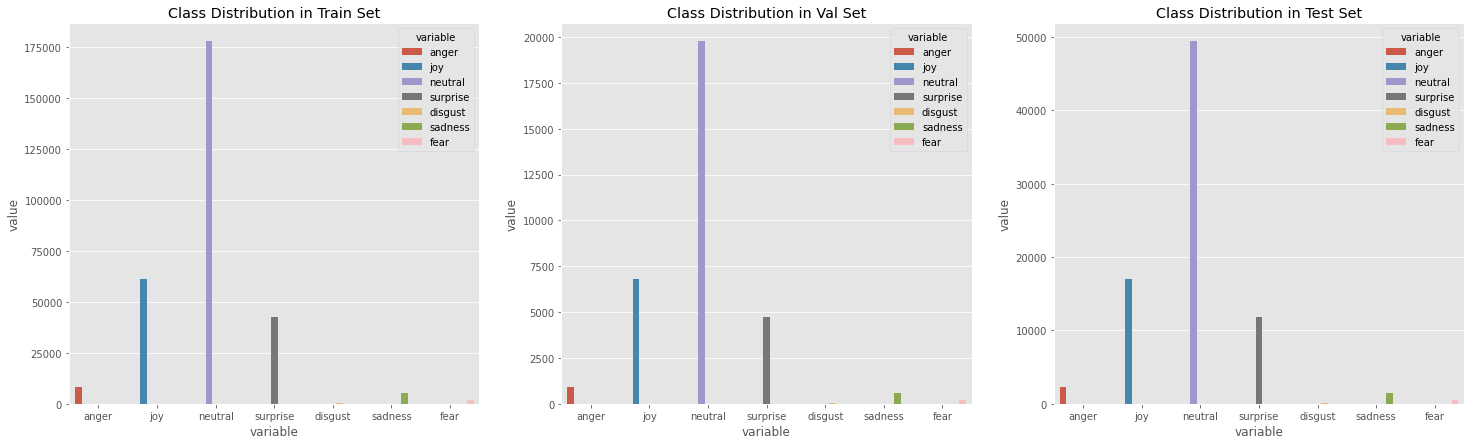

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Text(0.5, 1.0, 'Class Distribution in Test Set')

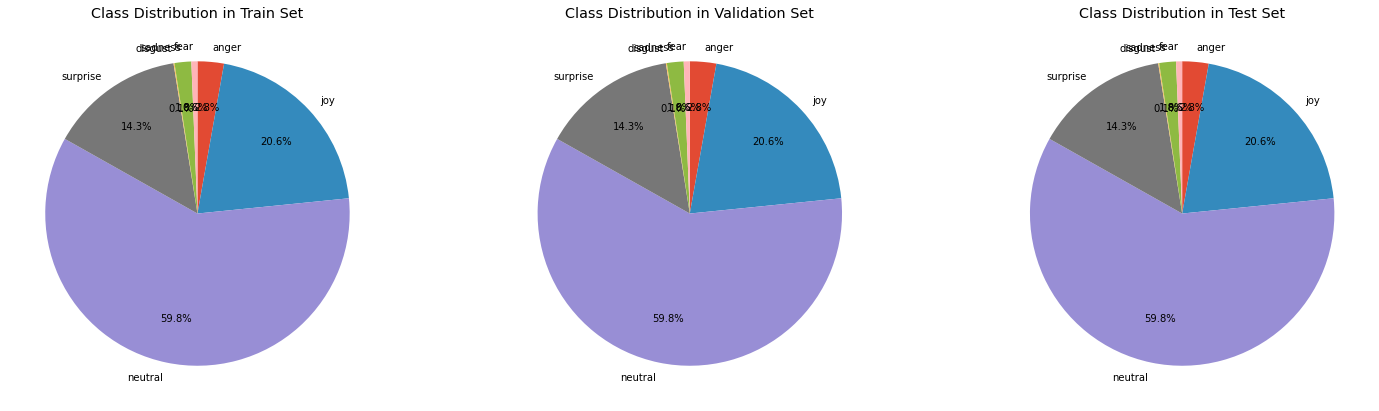

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
#sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
axes[0].pie((pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[0].set_title("Class Distribution in Train Set")

# Validation
axes[1].pie((pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[1].set_title("Class Distribution in Validation Set")
# Test
axes[2].pie((pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[2].set_title("Class Distribution in Test Set")

In [ ]:
# Neural Network
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
# Model Parameters
EPOCHS = 100 #original 300
BATCH_SIZE = 32 #original 16
LEARNING_RATE = 0.01

NUM_FEATURES = len(X.columns)-3
NUM_CLASSES = 7

In [ ]:
# Dataloader
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True
    #sampler = weighted_sampler
)

val_loader = DataLoader(dataset = val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=False)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=411, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# Cross-entropy error function
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Loss log
record_loss_train = []
record_loss_test = []

# Learning
for e in tqdm(range(1, EPOCHS+1)):  # Epoch Learning

    model.train()  # Training mode
    loss_train = 0.0
    for j, (x, t) in enumerate(train_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()  # GPU
        optimizer.zero_grad()

        y = model(x)
        loss = loss_fnc(y, t)

        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_train += torch.mean(pred.eq(t).float())
        
    loss_train /= j+1
    record_loss_train.append(loss_train/len(train_loader))

    model.eval()  # validation
    loss_val = 0.0

    for j, (x, t) in enumerate(val_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = loss_fnc(y, t)
        loss_val += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_val += torch.mean(pred.eq(t).float())
    

    loss_val /= j+1
    record_loss_test.append(loss_val/len(val_loader))

    if e%10 == 0:
        print("Epoch:", e, "Loss_Train:", loss_train, "Loss_Test:", loss_val)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 Loss_Train: 1.0213575436487186 Loss_Test: 1.0256289774355092
Epoch: 20 Loss_Train: 0.9671855782908718 Loss_Test: 0.9645897997391671
Epoch: 30 Loss_Train: 0.919501640973828 Loss_Test: 0.9292098578027381
Epoch: 40 Loss_Train: 0.8760552108512154 Loss_Test: 0.8940937403158395
Epoch: 50 Loss_Train: 0.8383832790990301 Loss_Test: 0.8685488956799982
Epoch: 60 Loss_Train: 0.8039779855155319 Loss_Test: 0.8311956688079003
Epoch: 70 Loss_Train: 0.7736137558188614 Loss_Test: 0.826353917754723
Epoch: 80 Loss_Train: 0.7480879479588354 Loss_Test: 0.8180055346046744
Epoch: 90 Loss_Train: 0.723548114088251 Loss_Test: 0.8064607713351096
Epoch: 100 Loss_Train: 0.7028687741823357 Loss_Test: 0.7739106881334591


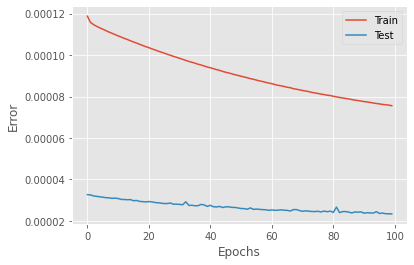

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []


columnlist = list(df.columns)[0:-1]+["emotion","label"]
print (columnlist)
correctdf = pd.DataFrame(columns=columnlist)
faildf = pd.DataFrame(columns=columnlist)
correctcount = 0
failcount = 0
for i, ((x, t),(x1)) in enumerate(zip(test_loader,X_test_temp)):
    #print (x[0,:])
    x, t = x.cuda(), t.cuda()  # GPU
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    labels = t.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == t).sum().item()
    
    if y.argmax(1)==t and correctcount<1001:
      temp = [x1.reshape(1,414).tolist()[0]+[output[0],labels[0]]]
      correctdf = correctdf.append(pd.DataFrame(temp,columns=columnlist))
      correctcount +=1

    elif y.argmax(1)!=t and failcount<1001:
      temp = [x1.reshape(1,414).tolist()[0]+[output[0],labels[0]]]
      #print (temp)
      faildf = faildf.append(pd.DataFrame(temp,columns=columnlist))
      failcount +=1

    total += len(x)
print("正解率:", str(correct/total*100) + "%")
print(correctdf.head())
print(faildf.head())

['frame', 'Nose_x', 'Nose_y', 'Nose_c', 'Neck_x', 'Neck_y', 'Neck_c', 'RShoulder_x', 'RShoulder_y', 'RShoulder_c', 'RElbow_x', 'RElbow_y', 'RElbow_c', 'RWrist_x', 'RWrist_y', 'RWrist_c', 'LShoulder_x', 'LShoulder_y', 'LShoulder_c', 'LElbow_x', 'LElbow_y', 'LElbow_c', 'LWrist_x', 'LWrist_y', 'LWrist_c', 'MidHip_x', 'MidHip_y', 'MidHip_c', 'RHip_x', 'RHip_y', 'RHip_c', 'RKnee_x', 'RKnee_y', 'RKnee_c', 'RAnkle_x', 'RAnkle_y', 'RAnkle_c', 'LHip_x', 'LHip_y', 'LHip_c', 'LKnee_x', 'LKnee_y', 'LKnee_c', 'LAnkle_x', 'LAnkle_y', 'LAnkle_c', 'REye_x', 'REye_y', 'REye_c', 'LEye_x', 'LEye_y', 'LEye_c', 'REar_x', 'REar_y', 'REar_c', 'LEar_x', 'LEar_y', 'LEar_c', 'LBigToe_x', 'LBigToe_y', 'LBigToe_c', 'LSmallToe_x', 'LSmallToe_y', 'LSmallToe_c', 'LHeel_x', 'LHeel_y', 'LHeel_c', 'RBigToe_x', 'RBigToe_y', 'RBigToe_c', 'RSmallToe_x', 'RSmallToe_y', 'RSmallToe_c', 'RHeel_x', 'RHeel_y', 'RHeel_c', 'face_point0_x', 'face_point0_y', 'face_point0_c', 'face_point1_x', 'face_point1_y', 'face_point1_c', 'face_

In [ ]:
#correctdf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/ekman/model01(3NN_Epoch100)/correct_df.csv")
#faildf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/ekman/model01(3NN_Epoch100)/incorrect_df.csv")

[[  762   141  1337    48     6    16     3]
 [   52  5592 10645   700     0    32     8]
 [  141  2496 45219  1454     4    71    10]
 [   23   687  7846  3269     2     9     0]
 [    7     5    27     1    48     0     0]
 [   23    97   765    30     2   544     3]
 [   15    26   281    30     2     3   174]]


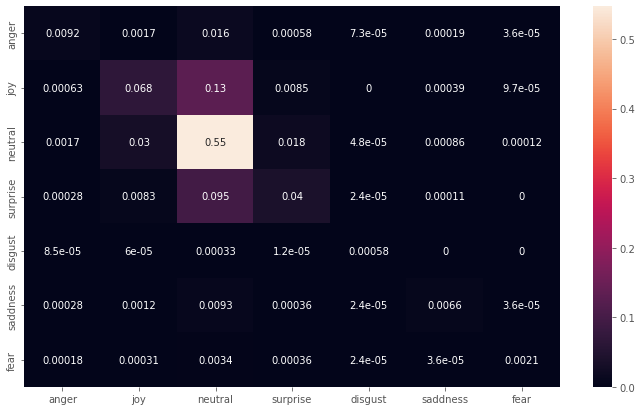

In [ ]:
import seaborn as sn
classes = ('anger', 'joy', 'neutral', 'surprise', 'disgust',
        'saddness', 'fear')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/ekman/model01(3NN_Epoch100)/pytorch_epoch100_model.pth")

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.33      0.46      2313
           1       0.62      0.33      0.43     17029
           2       0.68      0.92      0.78     49395
           3       0.59      0.28      0.38     11836
           4       0.75      0.55      0.63        88
           5       0.81      0.37      0.51      1464
           6       0.88      0.33      0.48       531

    accuracy                           0.67     82656
   macro avg       0.72      0.44      0.52     82656
weighted avg       0.66      0.67      0.64     82656

